### This notebook plays around with node degrees and looks at the impact of systematically deleting SC ...

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
Davide_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Neg_Corrs_Jam_Session_June_2022/Davide_HCP_Data_Matrix'

ShreyVB_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Neg_Corrs_Jam_Session_June_2022'

Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/Sub_Specific_SC_Wts_2'

pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

# _sub_list = [200614, 199958, 177746, 164131, 141826, 130619, 127933, 116726, 100307, 100206]
# sub_list = list(reversed(_sub_list))

parcs = np.arange(0,200,1)

In [4]:
# %%
# define options for wong-wang model
node_size = 200
mask = np.tril_indices(node_size, -1)
num_epoches = 20 #50
batch_size = 20
step_size = 0.05
input_size = 2
tr = 2.0
repeat_size = 5

In [5]:
sub_list_1 = [100610, 103111, 118528, 139637, 144428, 158136, 182739, 102513, 102816, 107321, 107422, 108525, 112112, 121618, 129331]
sub_list_2 = [129634, 132118, 133625, 133827, 134829, 137936, 153227, 154936, 156334, 173435]
sub_list = np.concatenate((sub_list_1, sub_list_2))
sub_list.sort()

In [6]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/shreyVB/scratch/Schaefer_200_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [7]:
def load_wts(sub_id):
    
    _gg = np.loadtxt(Wts_Path + "/{0}_SC_wts.txt".format(sub_id))

    # Structural Connectivity
    HCP_SC1 = _gg[parcs][:,parcs] 
    HCP_SC1 = HCP_SC1 + HCP_SC1.T # --> Symmetric
    pre_laplachian_HCP_SC = HCP_SC1.copy()

    # Laplachian!

    HCP_SC = -np.diag((pre_laplachian_HCP_SC/np.linalg.norm(pre_laplachian_HCP_SC)).sum(0)) + pre_laplachian_HCP_SC/np.linalg.norm(pre_laplachian_HCP_SC)
    
    return pre_laplachian_HCP_SC, HCP_SC

In [8]:
%%time
all_subs_pre_lap_SC = []
all_subs_HCP_SC = []

for i in range(len(sub_list)):
    pre_lap_SC, ss_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)
    all_subs_HCP_SC.append(ss_SC)

CPU times: user 936 ms, sys: 13.4 ms, total: 950 ms
Wall time: 7.94 s


In [9]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [10]:
def load_FC(sub_id):
    
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
#     pconn1RL = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)
#     pconn2LR = pconn_path + '{0}_rfMRI_REST2_LR_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)
#     pconn2RL = pconn_path + '{0}_rfMRI_REST2_RL_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)
    
    _pconn_img1LR = nib.load(pconn1LR)
    _pconn_dat1LR = _pconn_img1LR.get_data()
    _pconn_dat1LR = _pconn_dat1LR/1

#     _pconn_img1RL = nib.load(pconn1RL)
#     _pconn_dat1RL = _pconn_img1RL.get_data()
#     _pconn_dat1RL = _pconn_dat1RL/1

#     _pconn_img2LR = nib.load(pconn2LR)
#     _pconn_dat2LR = _pconn_img2LR.get_data()
#     _pconn_dat2LR = _pconn_dat2LR/1

#     _pconn_img2RL = nib.load(pconn2RL)
#     _pconn_dat2RL = _pconn_img2RL.get_data()
#     _pconn_dat2RL = _pconn_dat2RL/1
    
#     _test_pconn = (_pconn_dat1LR + _pconn_dat1LR + _pconn_dat2LR + _pconn_dat2RL)/4
    
    return _pconn_dat1LR

In [11]:
%%time
all_subs_pconn1LR = []
# all_subs_pconn1RL = []
# all_subs_pconn2LR = []
# all_subs_pconn2RL = []
# all_subs_FC = []


for i in range(len(sub_list)):

    _1LR = load_FC(sub_list[i])
    all_subs_pconn1LR.append(_1LR)
#     all_subs_pconn1RL.append(_1RL)
#     all_subs_pconn2LR.append(_2LR)
#     all_subs_pconn2RL.append(_2RL)
#     all_subs_FC.append(avg_ss_pconn)

CPU times: user 8.03 s, sys: 44.1 ms, total: 8.07 s
Wall time: 19 s


In [12]:
data_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/HCP_200_parcs'

In [36]:
def open_pickles(sub_id):
    filename = data_path + '/Subj_{0}_fittingresults_stim_exp.pkl'.format(sub_id)
    with open(filename, 'rb') as f:
        g = pickle.load(f)
    
    outfilename = data_path + '/Subj_{0}_simEEG_stim_exp.pkl'.format(sub_id)
    with open(outfilename, 'rb') as f1:
        g1 = pickle.load(f1)
    
    return g, g1

In [37]:
%%time
all_subs_fittingresults = []
all_subs_simEEG = []
for i in range(len(sub_list)):
    ss_fittingresult, ss_simEEG = open_pickles(sub_list[i])
    all_subs_fittingresults.append(ss_fittingresult)
    all_subs_simEEG.append(ss_simEEG)

CPU times: user 6.86 s, sys: 25.7 s, total: 32.5 s
Wall time: 1min 2s


In [15]:
# 

### calculate the node degree of the fitted SC matrix

In [30]:
og_data_all_subs = all_subs_fittingresults.copy()

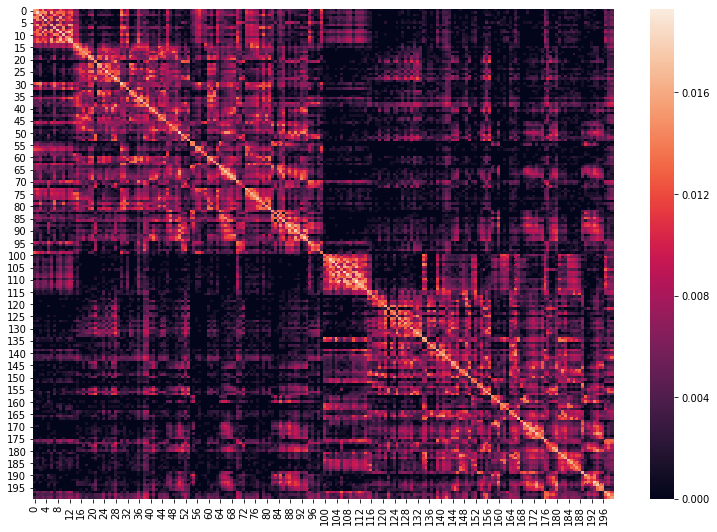

In [17]:
fig, ax = plt.subplots(figsize=(13,9))
sns.heatmap(og_data_all_subs[0].model.sc)

In [18]:
# model.gains_con is the modification/change to the original SC. 

# Here is a simpler way to understand this ...

# original_sc * model.gains_con = fitted_sc

In [31]:
fitted_sc3 = np.abs(og_data_all_subs[0].model.gains_con.detach().numpy())

In [32]:
node_degree_all_nodes3 = []
for i in range(len(fitted_sc3)):
    node_degree = np.sum(fitted_sc3[i])
    node_degree_all_nodes3.append(node_degree)
    

value_index_pairs3 = list(enumerate(node_degree_all_nodes3))

sorted_pairs3 = sorted(value_index_pairs3, key=lambda x: x[1], reverse=True)

In [33]:
sorted_pairs3[0:10]

[(1, 744.8981),
 (86, 635.83563),
 (90, 598.05743),
 (165, 580.08887),
 (94, 579.8562),
 (88, 570.30664),
 (194, 549.0818),
 (198, 515.8624),
 (81, 513.554),
 (91, 503.42752)]

In [22]:
_df = pd.DataFrame(sorted_pairs3,columns=['Index','Node Degree'])
# _df.head()

idx_list = _df['Index'].tolist()

In [23]:
# first - make top 5 original sc rows = 0
# second - make top 5 model.gains_con = 0, this reverts the original sc to default value.

#### first - part 1: make bottom n original sc rows = 0

In [24]:
# make the first 100 model.gains_con sc rows = 0 ...
# based on the sorted model.gains_con (sorted_pairs3) 

In [25]:
_regions = idx_list[100:200]

In [26]:
_alternate_sc3 = og_data_all_subs[0].model.sc.copy()
_alternate_sc3[_regions,:] = 0

In [27]:
og_data_all_subs[0].model.sc = _alternate_sc3.copy()

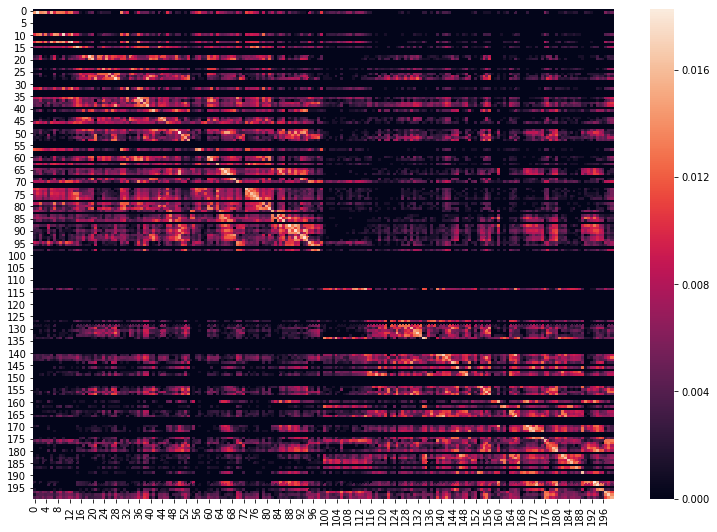

In [28]:
fig, ax = plt.subplots(figsize=(13,9))
sns.heatmap(og_data_all_subs[0].model.sc)

In [29]:
%%time

# run the model ...(test)
og_data_all_subs[0].test(20)

0.5498629897414431 cos_sim:  0.9955532282386542
CPU times: user 5min 2s, sys: 9.46 s, total: 5min 11s
Wall time: 5min 11s


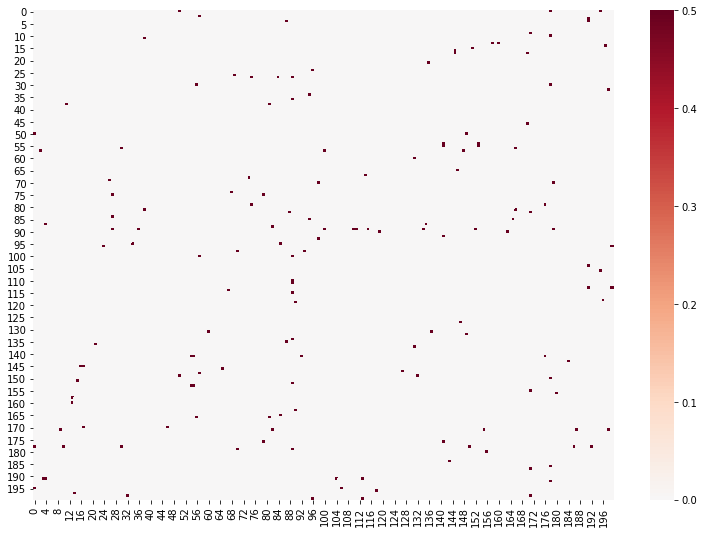

In [35]:
fig, ax = plt.subplots(figsize=(13,9))
sns.heatmap(np.corrcoef(og_data_all_subs[0].output_sim.bold_test)<-0.1,cmap='RdBu_r',center=0,vmax=0.5)

### For multiple subjects

In [38]:
%%time

b = 25
og_data_all_subs = all_subs_fittingresults.copy()

for i in range(25):
    
    fitted_sc3 = np.abs(og_data_all_subs[i].model.gains_con.detach().numpy())
    
    value_index_pairs3 = []
    sorted_pairs3 = []
    node_degree_all_nodes3 = []
    for j in range(len(fitted_sc3)):
        node_degree = np.sum(fitted_sc3[j])
        node_degree_all_nodes3.append(node_degree)
    

    value_index_pairs3 = list(enumerate(node_degree_all_nodes3))

    sorted_pairs3 = sorted(value_index_pairs3, key=lambda x: x[1], reverse=True)
    
    _df = pd.DataFrame(sorted_pairs3,columns=['Index','Node Degree'])
    idx_list = _df['Index'].tolist()
    
    _regions = idx_list[100:200]
    
    _alternate_sc3 = og_data_all_subs[i].model.sc.copy()
    _alternate_sc3[_regions,:] = 0
    
    og_data_all_subs[i].model.sc = _alternate_sc3.copy()
    
    print("running model on test data for subj {0} of {1} ... \n".format(i+1,b))
    # run the model ...(test)
    og_data_all_subs[i].test(20)

running model on test data for subj 1 of 25 ... 

0.5515474659250099 cos_sim:  0.9955452552618226
running model on test data for subj 2 of 25 ... 

0.741106670067044 cos_sim:  0.9947831275211132
running model on test data for subj 3 of 25 ... 

0.6391479696519958 cos_sim:  0.9969720963972688
running model on test data for subj 4 of 25 ... 

0.533310557264549 cos_sim:  0.9962181537447644
running model on test data for subj 5 of 25 ... 

0.5425738109365731 cos_sim:  0.9959465911107648
running model on test data for subj 6 of 25 ... 

0.6210011328025554 cos_sim:  0.9958719655179548
running model on test data for subj 7 of 25 ... 

0.5658756681168716 cos_sim:  0.9958220721759043
running model on test data for subj 8 of 25 ... 

0.6871935325632016 cos_sim:  0.9968916756373655
running model on test data for subj 9 of 25 ... 

0.5798382010093935 cos_sim:  0.9958003152797008
running model on test data for subj 10 of 25 ... 

0.558123439443822 cos_sim:  0.9961971615576225
running model on test 

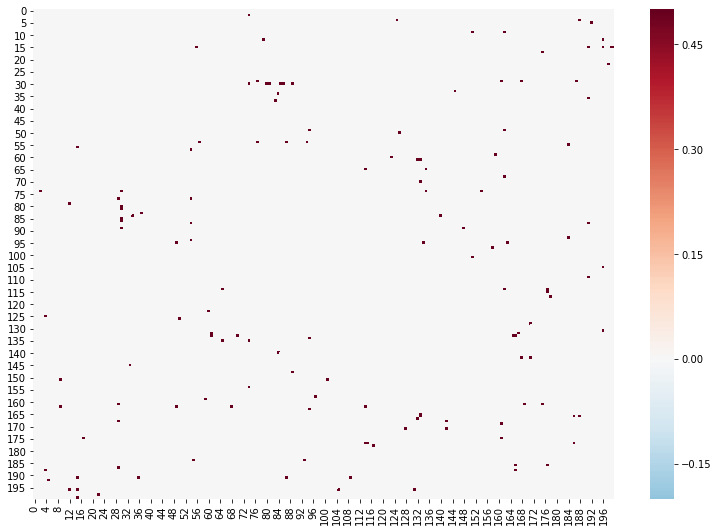

In [46]:
fig, ax = plt.subplots(figsize=(13,9))
sns.heatmap(np.corrcoef(og_data_all_subs[0].output_sim.bold_test)<-0.1,cmap='RdBu_r',center=0,vmax=0.5,vmin=-0.2)

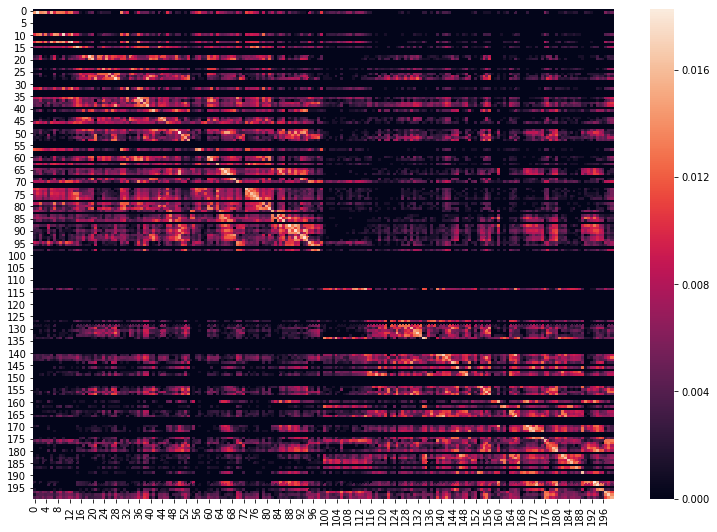

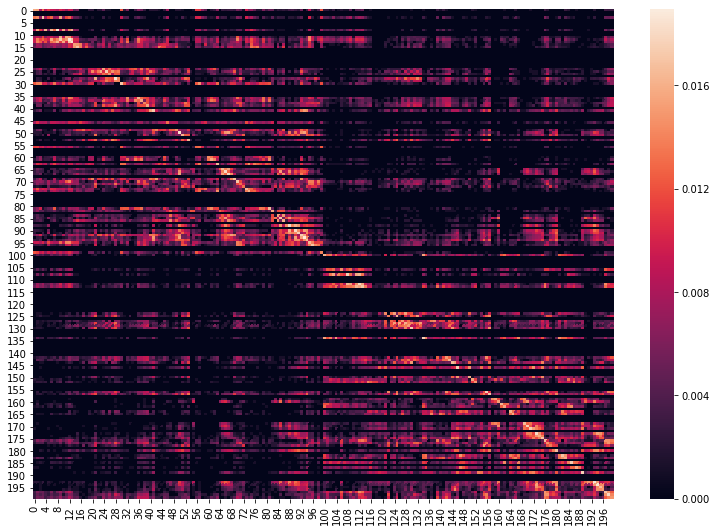

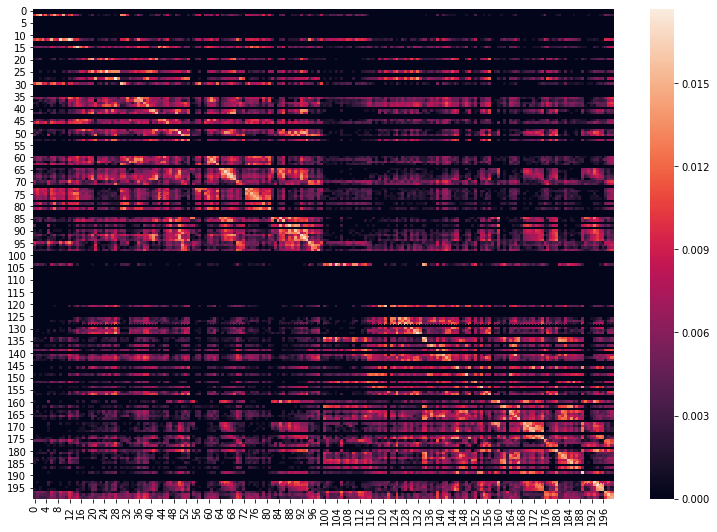

In [39]:
for i in range(3):
    fig, ax = plt.subplots(figsize=(13,9))
    sns.heatmap(og_data_all_subs[i].model.sc)

#### second - make top 5 model.gains_con = 0, this reverts the original sc to default value.

In [ ]:
og_data_all_subs = all_subs_fittingresults.copy()

In [ ]:
_alternate_sc4 = og_data_all_subs[0].model.gains_con.detach().numpy().copy()
_alternate_sc4[_regions,:] = 0

In [ ]:
import torch

In [ ]:
og_data_all_subs[0].model.gains_con = torch.nn.Parameter(torch.from_numpy(_alternate_sc4))

In [ ]:
%%time

# run the model ...(test)
og_data_all_subs[0].test(30)

In [ ]:
fig, ax = plt.subplots(figsize=(13,9))
sns.heatmap(np.corrcoef(og_data_all_subs[0].output_sim.bold_test),cmap='RdBu_r',center=0,vmax=0.5)